# Transporter analysis of bacillus mother-spore

In [2]:
from __future__ import print_function, division, absolute_import

import sys

import qminospy
from qminospy.me2 import ME_NLP

# python imports
from copy import copy
import re
from os.path import join, dirname, abspath
import sys
from collections import defaultdict
import pickle

# third party imports
import pandas as pd
import cobra
from tqdm import tqdm
import numpy as np
import scipy

# COBRAme
import cobrame
from cobrame.util import building, mu, me_model_interface
from cobrame.io.json import save_json_me_model, save_reduced_json_me_model

# ECOLIme
import bacillusme
from bacillusme import (transcription, translation, flat_files, generics, formulas, compartments)
from cobrame.util.helper_functions import *

import copy
from scipy import stats
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
print(cobra.__file__)
print(cobrame.__file__)
print(bacillusme.__file__)
ecoli_files = dirname(abspath(bacillusme.__file__))
pd.set_option('display.max_colwidth', None)

/home/jt/work/cobrapy-0.5.11/cobra/io/sbml3.py:24: UserWarning: Install lxml for faster SBML I/O
  warn("Install lxml for faster SBML I/O")
/home/jt/work/cobrapy-0.5.11/cobra/io/__init__.py:12: UserWarning: cobra.io.sbml requires libsbml
  warn("cobra.io.sbml requires libsbml")


/home/jt/work/cobrapy-0.5.11/cobra/__init__.py
/home/jt/work/cobrame/cobrame/__init__.py
/home/jt/work/sporeme/bacillusme/__init__.py


## NMP supply

In [9]:
with open("./sporeme_solution_v4_proteomics_spoAQ.pickle", "rb") as outfile:
    sporeme = pickle.load(outfile)

In [10]:
for m in sporeme.metabolites.query(re.compile('^[guca][m]p_s$')):
    df = flux_based_reactions(sporeme,m.id,only_types=['MetabolicReaction'])
    prod = df[df['met_flux']>0]['met_flux']
    prod = prod.div(prod.sum())
    top = df.sort_values('met_flux').iloc[[-1]]
    print(m)
    if top['met_flux'][0] > 0:
        print(top['reaction'][0])
        print(top['met_flux'][0])
        print('{} %'.format(str(prod.loc[top.index[0]]*100)))
    else:
        print('No production')
    print('\n')

ump_s
30.0 h2o_s + 30.0 uacgala_s + 30.0 udpg_s --> -4.27350427350427e-6*sigma CPLX000-68_s + 60.0 h_s + tcam_BS_s + 30.0 udp_s + 30.0 ump_s
0.01751091219586192
94.61520914952574 %


amp_s
atp_s + coa_s + fa4_s --> -4.27350427350427e-6*sigma BSU10360-MONOMER_s + amp_s + fa4coa_s + ppi_s
0.001954701594697792
18.941907159273992 %


cmp_s
45.0 cdpglyc_s + uacgam_s + uacmam_s --> -4.27350427350427e-6*sigma CPLX000-65_s + 45.0 cmp_s + gtca1_45_BS_s + 46.0 h_s + udp_s + ump_s
0.002925989044189453
21.816070640681275 %


gmp_s
gmp_c + h_c --> -4.27350427350427e-6*sigma PORE-CPLX_s + gmp_s + h_s
0.0016986845113613476
100.0 %




In [11]:
for r in sporeme.metabolites.get_by_id('BSU37150-MONOMER_mod_mg2').reactions:
    print(r.id)
    print(r.reaction)

CTPS1_FWD_BSU37150-MONOMER_mod_mg2
atp_c + gln__L_c + utp_c --> -4.27350427350427e-6*sigma BSU37150-MONOMER_mod_mg2 + adp_c + ctp_c + glu__L_c + 2.0 h_c + pi_c
CTPS2_FWD_BSU37150-MONOMER_mod_mg2
atp_c + gln__L_c + h2o_c + utp_c --> -3.27652483201383e-6*sigma BSU37150-MONOMER_mod_mg2 + adp_c + ctp_c + glu__L_c + 2.0 h_c + pi_c
formation_BSU37150-MONOMER_mod_mg2
mg2_c + 4.0 protein_BSU37150 --> BSU37150-MONOMER_mod_mg2 + 0.04861 prosthetic_group_biomass


### NDP and NTP transport

In [2]:
import sympy
import cobrame
import pickle
from cobrame.util.helper_functions import solve_me_model,flux_based_reactions
def gene_ko(model,genes):
    for g in genes:
        model.reactions.get_by_id('translation_{}'.format(g)).bounds = (0,0)
    return model

def load_spore_model(add_transport = False):
    with open("./sporeme_solution_v4_proteomics_spoAQ.pickle", "rb") as infile:
        model = pickle.load(infile)
    if add_transport:
        model = add_transport_to_model(model,add_transport)
    return model

def load_me_model():
    with open("/home/jt/work/bacillusme-master/bacillusme/me_models/iJT964-ME.pickle", "rb") as infile:
        model = pickle.load(infile)
    return model

def get_response(model,
                 growth_key='mu',
                   max_mu = 0.002,
                   min_mu = 0,
                   using_soplex=False,
                   precision = 1.0,
                   verbosity=0):
    solve_me_model(model,
                   max_mu = max_mu,
                   min_mu = min_mu,
                   using_soplex=using_soplex,
                   precision = precision,
                   growth_key = growth_key,
                   verbosity=verbosity)
    if model.solution:
        return model.solution.x_dict#['biomass_dilution_s']
    else:
        return {r.id:0. for r in model.reactions}
    
def add_transport_to_model(model,met,cplx = 'PORE-CPLX'):
    rxn = cobrame.MEReaction('{}_FWD_transport'.format(met))
    model.add_reactions([rxn])
    rxn.add_metabolites({
        '{}_c'.format(met):-1,
        '{}_s'.format(met):1
        # cplx:sympy.Symbol('-4.27350427350427e-6*sigma')
    })
    rxn.bounds = (0,1000)
    
    rxn = cobrame.MEReaction('{}_REV_transport'.format(met))
    model.add_reactions([rxn])
    rxn.add_metabolites({
        '{}_c'.format(met):1,
        '{}_s'.format(met):-1
        # cplx+'_s':sympy.Symbol('-4.27350427350427e-6*sigma')
    })
    rxn.bounds = (0,1000)
#     print(rxn.metabolites)
    return model
    
def test_essentiality(genes,add_transport=False):
    d = {}
    # No deg
    print('No deg')
    model = load_spore_model()
    d['no_deg'] = get_response(model,growth_key='sigma')
    print(d['no_deg']['biomass_dilution_s'])
    
    # MC
    print('MC')
    model = load_spore_model(add_transport=add_transport)
    mc_genes = [i for i in genes]
    model = gene_ko(model,mc_genes)
    d['MC'] = get_response(model,growth_key='sigma')
    print(d['MC']['biomass_dilution_s'])
    
    # FS
    print('FS')
    model = load_spore_model(add_transport=add_transport)
    fs_genes = [i+'_s' for i in genes]
    model = gene_ko(model,fs_genes)
    d['FS'] = get_response(model,growth_key='sigma')
    print(d['FS']['biomass_dilution_s'])
    
    # Both
    print('Both')
    model = load_spore_model(add_transport=add_transport)
    both_genes = mc_genes + fs_genes
    model = gene_ko(model,both_genes)
    d['both'] = get_response(model,growth_key='sigma')
    print(d['both']['biomass_dilution_s'])
    
    # Germination
    print('Germination')
    model = load_me_model() 
    model = gene_ko(model,genes)
    d['germination'] = get_response(model,growth_key='mu')
    print(d['germination']['biomass_dilution'])
    return d

In [3]:
sporeme = load_spore_model()

In [4]:
me = load_me_model()

In [5]:
results = {}

In [6]:
results['gmk'] = {}
results['gmk']['no_transport'] = test_essentiality(['BSU15680']) # gmk
results['gmk']['gdp_transport'] = test_essentiality(['BSU15680'],add_transport = 'gdp') # gmk
results['gmk']['gtp_transport'] = test_essentiality(['BSU15680'],add_transport = 'gtp') # gmk

No deg
 Allocating name1, name2
 Allocating pi, rc, xn
 Allocated pi, rc, xn
 No Jacobian matrix since no nonlinear obj or constraints
C0028000000000000000000000000000
 C028000000000000
C0028000000000000000000000000000
C083D6329F1C35CA5000000000000000
 C83D6329F1C35CA5
C083D6329F1C35CA5000000000000000
4083D6329F1C35CA5000000000000000
 483D6329F1C35CA5
4083D6329F1C35CA5000000000000000
 Calling miopt to set option: Maximize
 Calling miopt to set option: Solution No
 Calling miopti to set option New basis file to           11
 Calling miopti to set option Save frequency to       500000
 Calling miopti to set option Print level to            0
 Calling miopti to set option Print frequency to       100000
 Calling miopti to set option Scale option to            2
 Calling miopti to set option Iteration limit to      2000000
 Calling miopti to set option Expand frequency to       100000
 46293E5939A08CEA
406293E5939A08CEA000000000000000
 Calling mioptr to set option Penalty parameter to    1

In [8]:
results['cmk'] = {}
results['cmk']['no_transport'] = test_essentiality(['BSU22890']) # cmk
results['cmk']['cdp_transport'] = test_essentiality(['BSU22890'],add_transport = 'cdp')
results['cmk']['ctp_transport'] = test_essentiality(['BSU22890'],add_transport = 'ctp')

No deg
 Allocating name1, name2
 Allocating pi, rc, xn
 Allocated pi, rc, xn
 No Jacobian matrix since no nonlinear obj or constraints
C0028000000000000000000000000000
 C028000000000000
C0028000000000000000000000000000
C083D6329F1C35CA5000000000000000
 C83D6329F1C35CA5
C083D6329F1C35CA5000000000000000
4083D6329F1C35CA5000000000000000
 483D6329F1C35CA5
4083D6329F1C35CA5000000000000000
 Calling miopt to set option: Maximize
 Calling miopt to set option: Solution No
 Calling miopti to set option New basis file to           11
 Calling miopti to set option Save frequency to       500000
 Calling miopti to set option Print level to            0
 Calling miopti to set option Print frequency to       100000
 Calling miopti to set option Scale option to            2
 Calling miopti to set option Iteration limit to      2000000
 Calling miopti to set option Expand frequency to       100000
 46293E5939A08CEA
406293E5939A08CEA000000000000000
 Calling mioptr to set option Penalty parameter to    1

In [14]:
results['pyrG'] = {}
results['pyrG']['no_transport'] = test_essentiality(['BSU37150']) # pyrG
results['pyrG']['cdp_transport'] = test_essentiality(['BSU37150'],add_transport = 'cdp')
results['pyrG']['ctp_transport'] = test_essentiality(['BSU37150'],add_transport = 'ctp')

No deg
 Allocating name1, name2
 Allocating pi, rc, xn
 Allocated pi, rc, xn
 No Jacobian matrix since no nonlinear obj or constraints
C0028000000000000000000000000000
 C028000000000000
C0028000000000000000000000000000
C083D6329F1C35CA5000000000000000
 C83D6329F1C35CA5
C083D6329F1C35CA5000000000000000
4083D6329F1C35CA5000000000000000
 483D6329F1C35CA5
4083D6329F1C35CA5000000000000000
 Calling miopt to set option: Maximize
 Calling miopt to set option: Solution No
 Calling miopti to set option New basis file to           11
 Calling miopti to set option Save frequency to       500000
 Calling miopti to set option Print level to            0
 Calling miopti to set option Print frequency to       100000
 Calling miopti to set option Scale option to            2
 Calling miopti to set option Iteration limit to      2000000
 Calling miopti to set option Expand frequency to       100000
 46293E5939A08CEA
406293E5939A08CEA000000000000000
 Calling mioptr to set option Penalty parameter to    1

In [7]:
results['cmk_pyrG'] = {}
results['cmk_pyrG']['no_transport'] = test_essentiality(['BSU22890','BSU37150']) # cmk + pyrG
results['cmk_pyrG']['cdp_transport'] = test_essentiality(['BSU22890','BSU37150'],add_transport = 'cdp')
results['cmk_pyrG']['ctp_transport'] = test_essentiality(['BSU22890','BSU37150'],add_transport = 'ctp')

No deg
 Allocating name1, name2
 Allocating pi, rc, xn
 Allocated pi, rc, xn
 No Jacobian matrix since no nonlinear obj or constraints
C0028000000000000000000000000000
 C028000000000000
C0028000000000000000000000000000
C083D6329F1C35CA5000000000000000
 C83D6329F1C35CA5
C083D6329F1C35CA5000000000000000
4083D6329F1C35CA5000000000000000
 483D6329F1C35CA5
4083D6329F1C35CA5000000000000000
 Calling miopt to set option: Maximize
 Calling miopt to set option: Solution No
 Calling miopti to set option New basis file to           11
 Calling miopti to set option Save frequency to       500000
 Calling miopti to set option Print level to            0
 Calling miopti to set option Print frequency to       100000
 Calling miopti to set option Scale option to            2
 Calling miopti to set option Iteration limit to      2000000
 Calling miopti to set option Expand frequency to       100000
 46293E5939A08CEA
406293E5939A08CEA000000000000000
 Calling mioptr to set option Penalty parameter to    1

In [15]:
with open("transport_results_high-spoAQ.pickle", "wb") as outfile:
    pickle.dump(results,outfile)

In [ ]:
with open("./transport_results_high-spoAQ.pickle", "rb") as f:
    results = pickle.load(f)

In [348]:
flux_dict = results['gmk']['gdp_transport']['FS']
# df = flux_based_reactions(sporeme,'gdp_s',flux_dict=flux_dict)
flux_dict['gdp_FWD_transport'],flux_dict['gdp_REV_transport']

(0.003303821460373403, 0.0)

In [349]:
flux_dict = results['gmk']['gdp_transport']['MC']
# df = flux_based_reactions(sporeme,'gdp_s',flux_dict=flux_dict)
flux_dict['gdp_FWD_transport'],flux_dict['gdp_REV_transport']

(0.0, 0.021647583908296315)

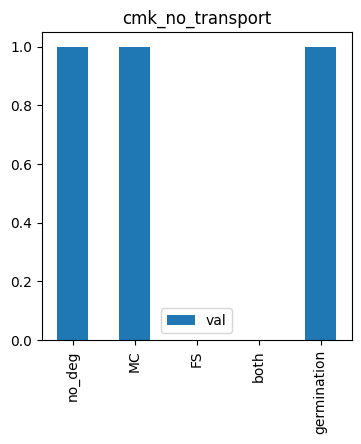

In [19]:
condition = 'no_transport'
gene = 'cmk'
d = {k:v['biomass_dilution_s'] if 'biomass_dilution_s' in v else v['biomass_dilution'] for k,v in results[gene][condition].items()}
df = pd.DataFrame.from_dict({'val':d})
df = df.div(df.max()).loc[['no_deg','MC','FS','both','germination']]
df.plot.bar(figsize=(4,4))
plt.title("{}_{}".format(gene,condition))
plt.savefig('./figures/stage_essentiality_{}_{}-spoAQ.svg'.format(gene,condition),format='SVG')

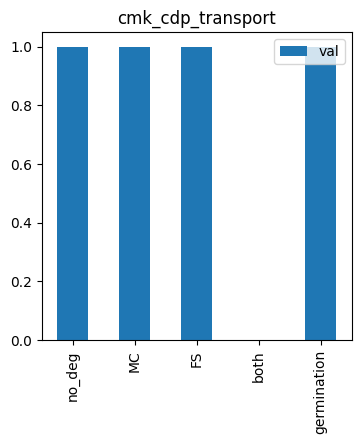

In [20]:
condition = 'cdp_transport'
gene = 'cmk'
d = {k:v['biomass_dilution_s'] if 'biomass_dilution_s' in v else v['biomass_dilution'] for k,v in results[gene][condition].items()}
df = pd.DataFrame.from_dict({'val':d})
df = df.div(df.max()).loc[['no_deg','MC','FS','both','germination']]
df.plot.bar(figsize=(4,4))
plt.title("{}_{}".format(gene,condition))
plt.savefig('./figures/stage_essentiality_{}_{}-spoAQ.svg'.format(gene,condition),format='SVG')

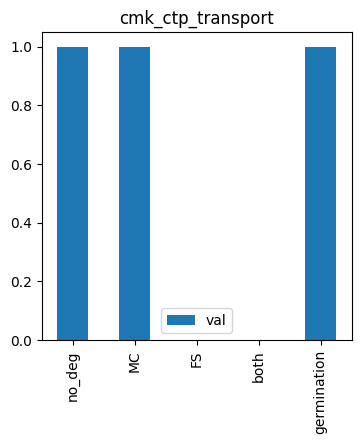

In [21]:
condition = 'ctp_transport'
gene = 'cmk'
d = {k:v['biomass_dilution_s'] if 'biomass_dilution_s' in v else v['biomass_dilution'] for k,v in results[gene][condition].items()}
df = pd.DataFrame.from_dict({'val':d})
df = df.div(df.max()).loc[['no_deg','MC','FS','both','germination']]
df.plot.bar(figsize=(4,4))
plt.title("{}_{}".format(gene,condition))
plt.savefig('./figures/stage_essentiality_{}_{}-spoAQ.svg'.format(gene,condition),format='SVG')

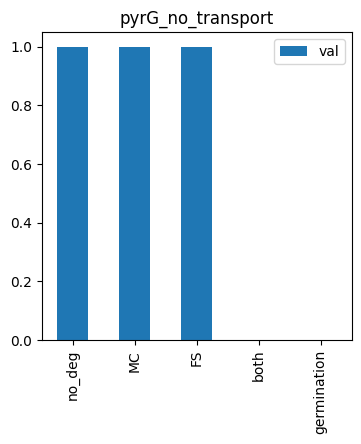

In [22]:
condition = 'no_transport'
gene = 'pyrG'
d = {k:v['biomass_dilution_s'] if 'biomass_dilution_s' in v else v['biomass_dilution'] for k,v in results[gene][condition].items()}
df = pd.DataFrame.from_dict({'val':d})
df = df.div(df.max()).loc[['no_deg','MC','FS','both','germination']]
df.plot.bar(figsize=(4,4))
plt.title("{}_{}".format(gene,condition))
plt.savefig('./figures/stage_essentiality_{}_{}-spoAQ.svg'.format(gene,condition),format='SVG')

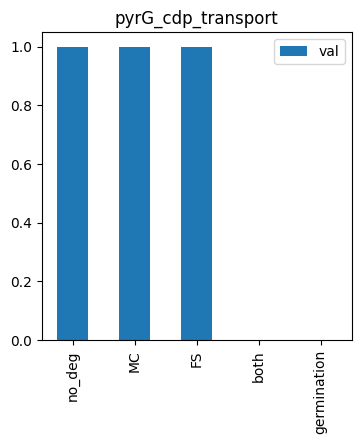

In [23]:
condition = 'cdp_transport'
gene = 'pyrG'
d = {k:v['biomass_dilution_s'] if 'biomass_dilution_s' in v else v['biomass_dilution'] for k,v in results[gene][condition].items()}
df = pd.DataFrame.from_dict({'val':d})
df = df.div(df.max()).loc[['no_deg','MC','FS','both','germination']]
df.plot.bar(figsize=(4,4))
plt.title("{}_{}".format(gene,condition))
plt.savefig('./figures/stage_essentiality_{}_{}-spoAQ.svg'.format(gene,condition),format='SVG')

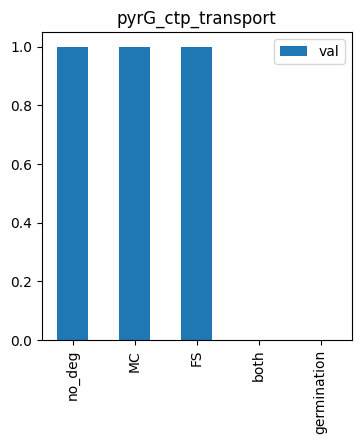

In [24]:
condition = 'ctp_transport'
gene = 'pyrG'
d = {k:v['biomass_dilution_s'] if 'biomass_dilution_s' in v else v['biomass_dilution'] for k,v in results[gene][condition].items()}
df = pd.DataFrame.from_dict({'val':d})
df = df.div(df.max()).loc[['no_deg','MC','FS','both','germination']]
df.plot.bar(figsize=(4,4))
plt.title("{}_{}".format(gene,condition))
plt.savefig('./figures/stage_essentiality_{}_{}-spoAQ.svg'.format(gene,condition),format='SVG')

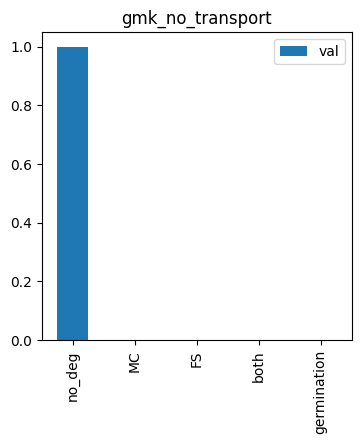

In [25]:
condition = 'no_transport'
gene = 'gmk'
d = {k:v['biomass_dilution_s'] if 'biomass_dilution_s' in v else v['biomass_dilution'] for k,v in results[gene][condition].items()}
df = pd.DataFrame.from_dict({'val':d})
df = df.div(df.max()).loc[['no_deg','MC','FS','both','germination']]
df.plot.bar(figsize=(4,4))
plt.title("{}_{}".format(gene,condition))
plt.savefig('./figures/stage_essentiality_{}_{}-spoAQ.svg'.format(gene,condition),format='SVG')

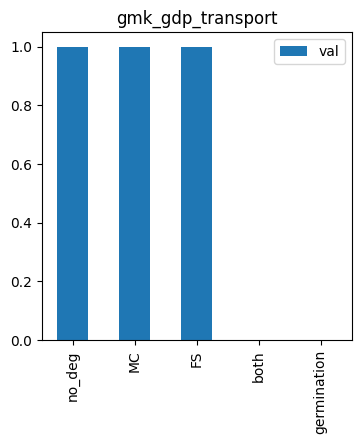

In [26]:
condition = 'gdp_transport'
gene = 'gmk'
d = {k:v['biomass_dilution_s'] if 'biomass_dilution_s' in v else v['biomass_dilution'] for k,v in results[gene][condition].items()}
df = pd.DataFrame.from_dict({'val':d})
df = df.div(df.max()).loc[['no_deg','MC','FS','both','germination']]
df.plot.bar(figsize=(4,4))
plt.title("{}_{}".format(gene,condition))
plt.savefig('./figures/stage_essentiality_{}_{}-spoAQ.svg'.format(gene,condition),format='SVG')

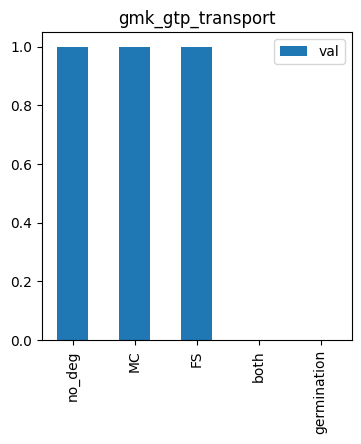

In [27]:
condition = 'gtp_transport'
gene = 'gmk'
d = {k:v['biomass_dilution_s'] if 'biomass_dilution_s' in v else v['biomass_dilution'] for k,v in results[gene][condition].items()}
df = pd.DataFrame.from_dict({'val':d})
df = df.div(df.max()).loc[['no_deg','MC','FS','both','germination']]
df.plot.bar(figsize=(4,4))
plt.title("{}_{}".format(gene,condition))
plt.savefig('./figures/stage_essentiality_{}_{}-spoAQ.svg'.format(gene,condition),format='SVG')

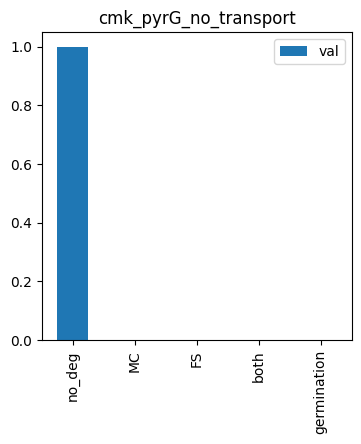

In [28]:
condition = 'no_transport'
gene = 'cmk_pyrG'
d = {k:v['biomass_dilution_s'] if 'biomass_dilution_s' in v else v['biomass_dilution'] for k,v in results[gene][condition].items()}
df = pd.DataFrame.from_dict({'val':d})
df = df.div(df.max()).loc[['no_deg','MC','FS','both','germination']]
df.plot.bar(figsize=(4,4))
plt.title("{}_{}".format(gene,condition))
plt.savefig('./figures/stage_essentiality_{}_{}-spoAQ.svg'.format(gene,condition),format='SVG')

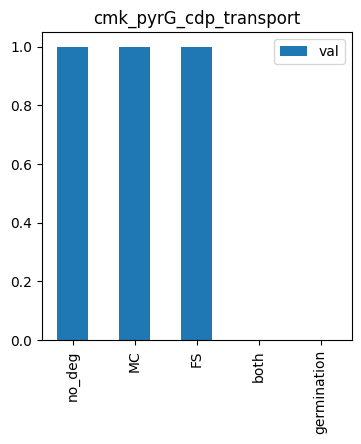

In [29]:
condition = 'cdp_transport'
gene = 'cmk_pyrG'
d = {k:v['biomass_dilution_s'] if 'biomass_dilution_s' in v else v['biomass_dilution'] for k,v in results[gene][condition].items()}
df = pd.DataFrame.from_dict({'val':d})
df = df.div(df.max()).loc[['no_deg','MC','FS','both','germination']]
df.plot.bar(figsize=(4,4))
plt.title("{}_{}".format(gene,condition))
plt.savefig('./figures/stage_essentiality_{}_{}-spoAQ.svg'.format(gene,condition),format='SVG')

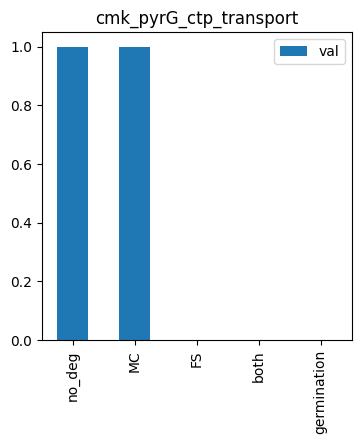

In [30]:
condition = 'ctp_transport'
gene = 'cmk_pyrG'
d = {k:v['biomass_dilution_s'] if 'biomass_dilution_s' in v else v['biomass_dilution'] for k,v in results[gene][condition].items()}
df = pd.DataFrame.from_dict({'val':d})
df = df.div(df.max()).loc[['no_deg','MC','FS','both','germination']]
df.plot.bar(figsize=(4,4))
plt.title("{}_{}".format(gene,condition))
plt.savefig('./figures/stage_essentiality_{}_{}-spoAQ.svg'.format(gene,condition),format='SVG')

### NDK

In [368]:
with open("./sporeme_solution_v4_proteomics.pickle", "rb") as outfile:
    sporeme = pickle.load(outfile)

In [ ]:
d = test_essentiality(['BSU15680'])
print(d)

No deg
 Allocating name1, name2
 Allocating pi, rc, xn
 Allocated pi, rc, xn
 No Jacobian matrix since no nonlinear obj or constraints
C0028000000000000000000000000000
 C028000000000000
C0028000000000000000000000000000
C083D6329F1C35CA5000000000000000
 C83D6329F1C35CA5
C083D6329F1C35CA5000000000000000
4083D6329F1C35CA5000000000000000
 483D6329F1C35CA5
4083D6329F1C35CA5000000000000000
 Calling miopt to set option: Maximize
 Calling miopt to set option: Solution No
 Calling miopti to set option New basis file to           11
 Calling miopti to set option Save frequency to       500000
 Calling miopti to set option Print level to            0
 Calling miopti to set option Print frequency to       100000
 Calling miopti to set option Scale option to            2
 Calling miopti to set option Iteration limit to      2000000
 Calling miopti to set option Expand frequency to       100000
 46293E5939A08CEA
406293E5939A08CEA000000000000000
 Calling mioptr to set option Penalty parameter to    1

In [ ]:
d = {k:v['biomass_dilution_s'] if 'biomass_dilution_s' in v else v['biomass_dilution'] for k,v in d.items()}
df = pd.DataFrame.from_dict({'val':d})
df = df.div(df.max()).loc[['no_deg','MC','FS','both','germination']]
df.plot.bar(figsize=(4,4))
plt.savefig('./figures/stage_essentiality_ndk-spoAQ.svg'.format(gene,condition),format='SVG')

### FVA

In [230]:
from qminospy.me2 import ME_NLP
sporeme.mu = "sigma"
obj_val = sporeme.solution.f
nlp = ME_NLP(sporeme, growth_key="sigma", growth_rxn="biomass_dilution_s")

In [219]:
mcrxns = ["translation_" + name_to_locus[g] for g in l]
fsrxns = ["translation_" + name_to_locus[g] + "_s" for g in l]
res = nlp.varyme(mu_fixed=0.99*obj_val, rxns_fva0 = [r for r in mcrxns + fsrxns if r in sporeme.reactions])
pd.DataFrame.from_dict(res[0]).T

Stacking J took 0.006555 seconds
Making I & V took 0.222948 seconds
Making P took 0.010704 seconds
Stacking bl & bu took 0.000462 seconds
 Allocating name1, name2
 Allocating pi, rc, xn
 Allocated hs, pi, rc, xn
 No Jacobian matrix since no nonlinear obj or constraints
C0028000000000000000000000000000
 C028000000000000
C0028000000000000000000000000000
C083D6329F1C35CA5000000000000000
 C83D6329F1C35CA5
C083D6329F1C35CA5000000000000000
4083D6329F1C35CA5000000000000000
 483D6329F1C35CA5
4083D6329F1C35CA5000000000000000
 Calling miopt to set option: Maximize
 Calling miopt to set option: Solution No
 Calling miopti to set option New basis file to           11
 Calling miopti to set option Save frequency to       500000
 Calling miopti to set option Print level to            0
 Calling miopti to set option Print frequency to       100000
 Calling miopti to set option Scale option to            2
 Calling miopti to set option Iteration limit to      2000000
 Calling miopti to set option Expa

,maximum,minimum
translation_BSU38980,5.539330e-24,5.539331e-24
translation_BSU11200,-6.161273e-39,-6.161273e-39
translation_BSU29140,4.588093e-32,4.588093e-32
translation_BSU30560,0.000000e+00,0.000000e+00
translation_BSU28310,0.000000e+00,0.000000e+00
translation_BSU13180,0.000000e+00,0.000000e+00
translation_BSU11220,0.000000e+00,0.000000e+00
translation_BSU11210,0.000000e+00,0.000000e+00
translation_BSU15530,1.033697e-32,1.033697e-32
translation_BSU14610,1.160304e-57,1.160304e-57


  -1.99341455760077914853382902348069207E-0025
3FACED8BA8742686D76A2111FB6FC380
 3ACED8BA8742686D
 Calling minoss. Warm start for subsequent run
  
 Quad MINOS finished.
 inform =           1
 ninf   =         147
 sinf   =   1.00396752397805629043758733980831950E-0005
 obj    =   0.00000000000000000000000000000000000      
                               0
                0
 Calling minoss. Warm start for subsequent run
  
 Quad MINOS finished.
 inform =           1
 ninf   =         147
 sinf   =   1.00396752397805629053040028259974229E-0005
 obj    =   0.00000000000000000000000000000000000      
                               0
                0
 Calling minoss. Warm start for subsequent run
  
 Quad MINOS finished.
 inform =           1
 ninf   =         147
 sinf   =   1.00396752397805490593924483280563740E-0005
 obj    =   0.00000000000000000000000000000000000      
                               0
                0
 Calling minoss. Warm start for subsequent run
  
 Quad MINOS fin

In [220]:
d = {}
for g in l:
    locus = name_to_locus[g]
    if not sporeme.metabolites.query(locus):
        print(g, ' not in model')
        continue
    mc = res[0]['translation_{}'.format(locus)]
    fs = res[0]['translation_{}_s'.format(locus)]
    d[g] = {'mc':mc,'fs':fs}
d

lutC  not in model


{'scoB': {'mc': {'maximum': 5.5393302071061074e-24,
   'minimum': 5.53933079008459e-24},
  'fs': {'maximum': 2.1468183592762418e-27,
   'minimum': 2.1468183592762418e-27}},
 'argJ': {'mc': {'maximum': -6.161273209126979e-39,
   'minimum': -6.161273209126979e-39},
  'fs': {'maximum': 0.0, 'minimum': 0.0}},
 'citZ': {'mc': {'maximum': 4.5880930465024147e-32,
   'minimum': 4.5880930465024147e-32},
  'fs': {'maximum': 0.0, 'minimum': 0.0}},
 'pckA': {'mc': {'maximum': 0.0, 'minimum': 0.0},
  'fs': {'maximum': 0.0, 'minimum': 0.0}},
 'ilvB': {'mc': {'maximum': 0.0, 'minimum': 0.0},
  'fs': {'maximum': 0.0, 'minimum': 0.0}},
 'metE': {'mc': {'maximum': 0.0, 'minimum': 0.0},
  'fs': {'maximum': 0.0, 'minimum': 0.0}},
 'argD': {'mc': {'maximum': 0.0, 'minimum': 0.0},
  'fs': {'maximum': 0.0, 'minimum': 0.0}},
 'argB': {'mc': {'maximum': 0.0, 'minimum': 0.0},
  'fs': {'maximum': 9.880657164506688e-31, 'minimum': 9.880657164506688e-31}},
 'pyrK': {'mc': {'maximum': 1.0336969826846225e-32,
   'mi